<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/EfficientNetB0/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNetB0 Transfer Learning for Pneumonia Detection

In [1]:
!nvidia-smi

Sat Oct 11 05:12:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install and import required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow keras numpy pandas matplotlib seaborn scikit-learn -q

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import os
import zipfile
from google.colab import files
import time
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [5]:
# Check GPU availability
print("\nGPU Available:", tf.test.is_gpu_available())
if tf.test.is_gpu_available():
    print("GPU Device:", tf.test.gpu_device_name())


GPU Available: True
GPU Device: /device:GPU:0


## Extract Dataset

In [6]:
import zipfile
import shutil

zip_path = "/content/drive/MyDrive/DL Assignment/archive.zip"

shutil.copy(zip_path, "/content/")

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile("/content/archive.zip", 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset structure:")
!find /content/chest_xray -type d -print


Extracting dataset...
Dataset structure:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/__MACOSX/chest_xray/val
/content/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/val/NORMAL
/content/chest_xray/__MACOSX/chest_xray/train
/content/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/train/NORMAL
/content/chest_xray/__MACOSX/chest_xray/test
/content/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/val/PNEUMONIA
/content/chest_xray/chest_xray/val/NORMAL
/content/chest_xray/chest_xray/train
/content/chest_xray/chest_xray/train/PNE

## Explore the Dataset

In [7]:
dataset_path = '/content/chest_xray'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'val')

def explore_dataset():
    print("Dataset Exploration:")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        split_path = os.path.join(dataset_path, split)
        normal_path = os.path.join(split_path, 'NORMAL')
        pneumonia_path = os.path.join(split_path, 'PNEUMONIA')

        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        total_count = normal_count + pneumonia_count

        print(f"\n{split.upper()} SET:")
        print(f"  Normal images: {normal_count}")
        print(f"  Pneumonia images: {pneumonia_count}")
        print(f"  Total images: {total_count}")
        print(f"  Pneumonia ratio: {pneumonia_count/total_count:.2%}")

explore_dataset()

📊 Dataset Exploration:

TRAIN SET:
  Normal images: 1341
  Pneumonia images: 3875
  Total images: 5216
  Pneumonia ratio: 74.29%

TEST SET:
  Normal images: 234
  Pneumonia images: 390
  Total images: 624
  Pneumonia ratio: 62.50%

VAL SET:
  Normal images: 8
  Pneumonia images: 8
  Total images: 16
  Pneumonia ratio: 50.00%


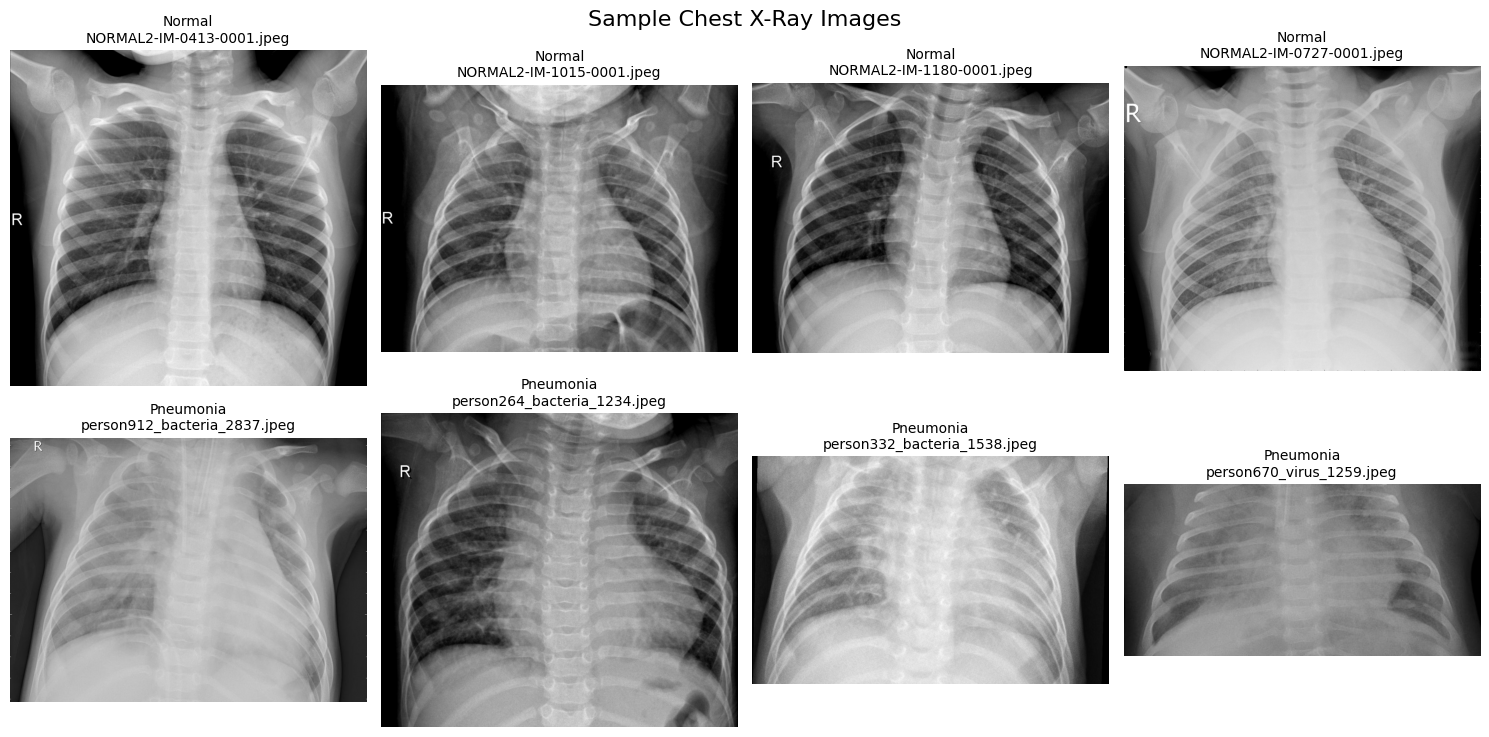

In [8]:
# Visualize sample images
def visualize_samples():
    """Display sample images from both classes"""
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Normal samples
    normal_path = os.path.join(train_path, 'NORMAL')
    normal_images = [f for f in os.listdir(normal_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(normal_images):
        img_path = os.path.join(normal_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Normal\n{img_name}', fontsize=10)
        axes[0, i].axis('off')

    # Pneumonia samples
    pneumonia_path = os.path.join(train_path, 'PNEUMONIA')
    pneumonia_images = [f for f in os.listdir(pneumonia_path) if f.endswith(('.jpeg', '.jpg', '.png'))][:4]

    for i, img_name in enumerate(pneumonia_images):
        img_path = os.path.join(pneumonia_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'Pneumonia\n{img_name}', fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle('Sample Chest X-Ray Images', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

visualize_samples()

## Data Preprocessing and Augmentation

In [13]:
IMG_HEIGHT = 224  # EfficientNet works well with 224x224
IMG_WIDTH = 224
BATCH_SIZE = 32

print("Setting up data generators...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

Setting up data generators...


In [12]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Display class information
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"\nData generators created successfully!")
print(f"Class indices: {class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class names: {class_names}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Data generators created successfully!
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training samples: 5216
Validation samples: 16
Test samples: 624
Class names: ['NORMAL', 'PNEUMONIA']


## Build EfficientNetB0 Transfer Learning Model

In [14]:
def create_efficientnet_model():
    """
    Create EfficientNetB0 transfer learning model for pneumonia detection
    """
    print("🛠️ Building EfficientNetB0 model...")

    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',       # Pre-trained on ImageNet
        include_top=False,        # Exclude the final classification layers
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Create the complete model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # More efficient than Flatten
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create the model
effnet_model = create_efficientnet_model()

# Display model summary
print("\n📋 Model Summary:")
effnet_model.summary()

🛠️ Building EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,416,676 (16.85 MB)

 Trainable params: 364,033 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

## Define Callbacks for Efficient Training

In [16]:
def setup_callbacks():
    """
    Set up callbacks for efficient training
    """
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )

    # Reduce learning rate when validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )

    # Save the best model
    checkpoint = ModelCheckpoint(
        'best_efficientnet_pneumonia_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return [early_stop, reduce_lr, checkpoint]

callbacks = setup_callbacks()
print("Callbacks setup complete!")

Callbacks setup complete!


## Train the Model

In [17]:
print("Starting model training...")
EPOCHS = 20

# Calculate steps per epoch
train_steps = train_generator.samples // BATCH_SIZE
val_steps = validation_generator.samples // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")
print(f"Maximum epochs: {EPOCHS}")

# Start timer
start_time = time.time()

# Train the model
history = effnet_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes!")

Starting model training...
Training steps per epoch: 163
Validation steps per epoch: 0
Maximum epochs: 20
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6665 - auc: 0.4921 - loss: 0.7081 - precision: 0.7397 - recall: 0.8475
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_efficientnet_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 801ms/step - accuracy: 0.6666 - auc: 0.4921 - loss: 0.7079 - precision: 0.7397 - recall: 0.8477 - val_accuracy: 0.5000 - val_auc: 0.6250 - val_loss: 0.7832 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.7167 - auc: 0.5026 - loss: 0.6341 - precision: 0.7463 - recall: 0.9411
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 695ms/step - accuracy: 0.7167 - auc: 0.5026 - loss: 0.6341 - precision: 0.7462 - recall: 0.9411 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.8135 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.7178 - auc: 0.5107 - loss: 0.6173 - precision: 0.7446 - recall: 0.9462
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.7178 - auc: 0.5107 - loss: 0.6173 - precisi

## Evaluate the Model

In [24]:
def evaluate_model_safe(model, test_generator):
    """
    Safe model evaluation that handles any metric name variations
    """
    print("\nEvaluating model on test set...")

    # Get the actual metric names
    print("Model metrics names:", model.metrics_names)

    # Evaluate and get results
    test_results = model.evaluate(test_generator, verbose=1, return_dict=True)

    print(f"\nTest Results:")
    print("Raw results:", test_results)

    # Extract metrics with flexible naming
    accuracy = test_results.get('accuracy', test_results.get('acc', 0.0))
    precision = test_results.get('precision', 0.0)
    recall = test_results.get('recall', 0.0)
    auc = test_results.get('auc', 0.0)

    print(f"Accuracy: {accuracy:.4f}")
    if precision > 0:
        print(f"Precision: {precision:.4f}")
    if recall > 0:
        print(f"Recall: {recall:.4f}")
    if auc > 0:
        print(f"AUC: {auc:.4f}")

    # Calculate F1-score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
        print(f"F1-Score: {f1_score:.4f}")

    # Make predictions
    print("\nMaking predictions...")
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # True labels
    true_classes = test_generator.classes

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=['NORMAL', 'PNEUMONIA'], digits=4))

    return test_results, predictions, predicted_classes

# Use this safe version
test_metrics, predictions, predicted_classes = evaluate_model_safe(effnet_model, test_generator)


Evaluating model on test set...
Model metrics names: ['loss', 'compile_metrics']
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.2984 - auc: 0.3588 - loss: 0.9570 - precision: 0.2984 - recall: 0.6667

Test Results:
Raw results: {'accuracy': 0.625, 'auc': 0.538034200668335, 'loss': 0.6753742098808289, 'precision': 0.625, 'recall': 1.0}
Accuracy: 0.6250
Precision: 0.6250
Recall: 1.0000
AUC: 0.5380
F1-Score: 0.7692

Making predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



## Visualize Results

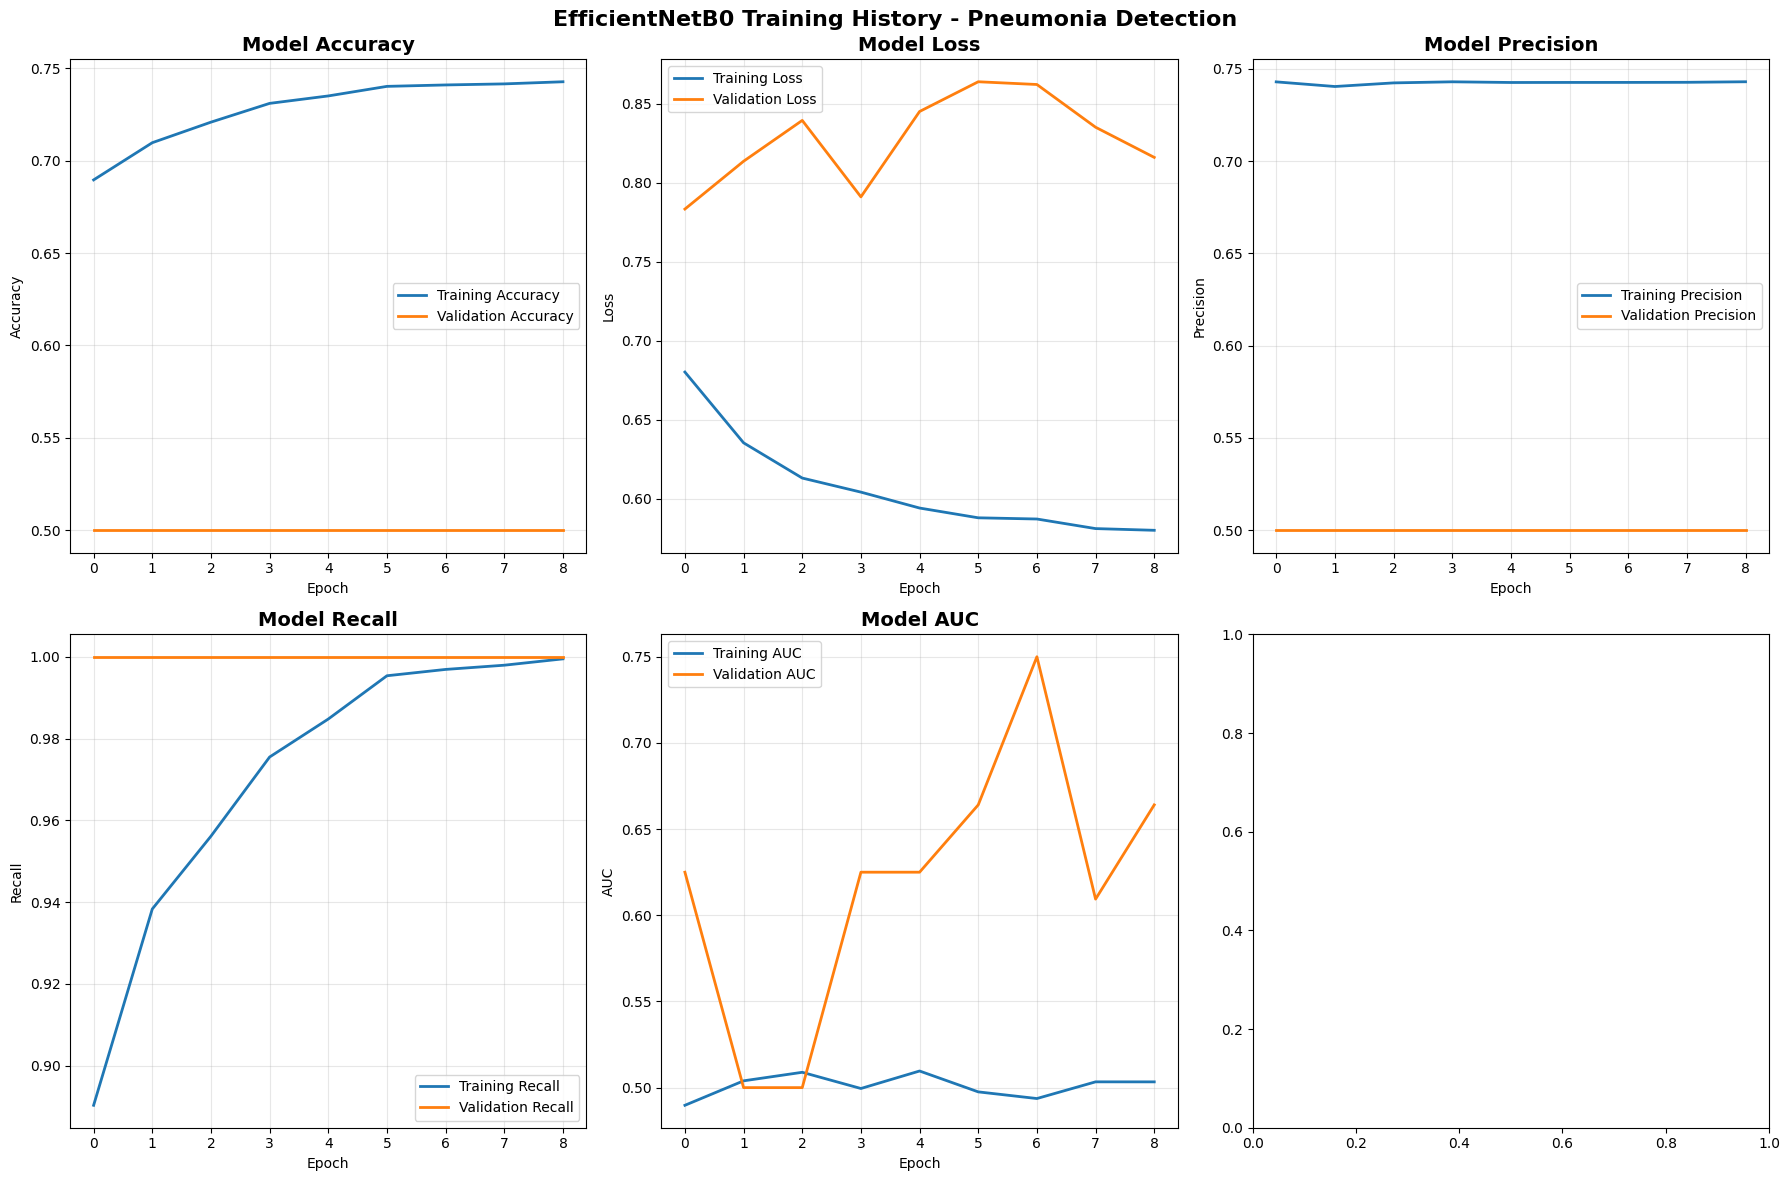

In [25]:
def plot_training_history(history):
    """
    Plot comprehensive training history
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[0, 2].plot(history.history['precision'], label='Training Precision', linewidth=2)
    axes[0, 2].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    axes[0, 2].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Recall
    axes[1, 0].plot(history.history['recall'], label='Training Recall', linewidth=2)
    axes[1, 0].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
    axes[1, 0].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # AUC
    if 'auc' in history.history:
        axes[1, 1].plot(history.history['auc'], label='Training AUC', linewidth=2)
        axes[1, 1].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
        axes[1, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('AUC')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    # Learning Rate
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='purple')
        axes[1, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Learning Rate')
        axes[1, 2].set_yscale('log')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

    plt.suptitle('EfficientNetB0 Training History - Pneumonia Detection', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

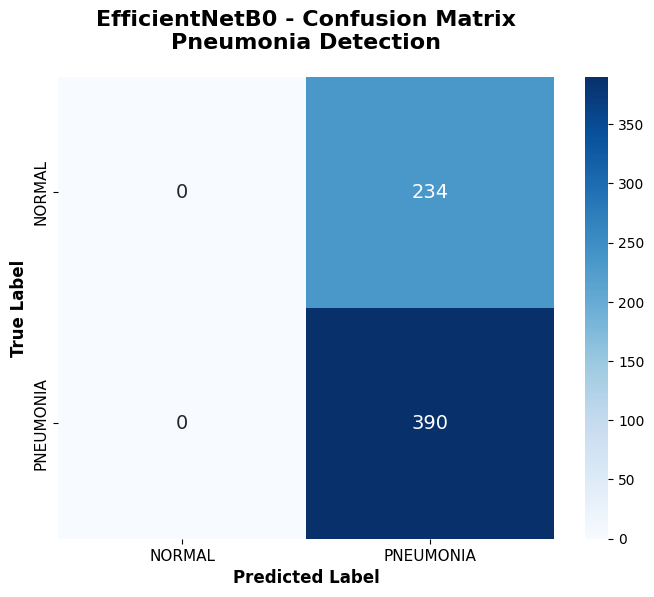

Confusion Matrix (Percentages):
[[  0. 100.]
 [  0. 100.]]


In [26]:
# Plot confusion matrix
def plot_confusion_matrix(test_generator, predicted_classes):
    """
    Plot detailed confusion matrix
    """
    cm = confusion_matrix(test_generator.classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={"size": 14})

    plt.title('EfficientNetB0 - Confusion Matrix\nPneumonia Detection',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

    # Calculate percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    print("Confusion Matrix (Percentages):")
    print(cm_percentage)

plot_confusion_matrix(test_generator, predicted_classes)

## Sample Predictions Visualization

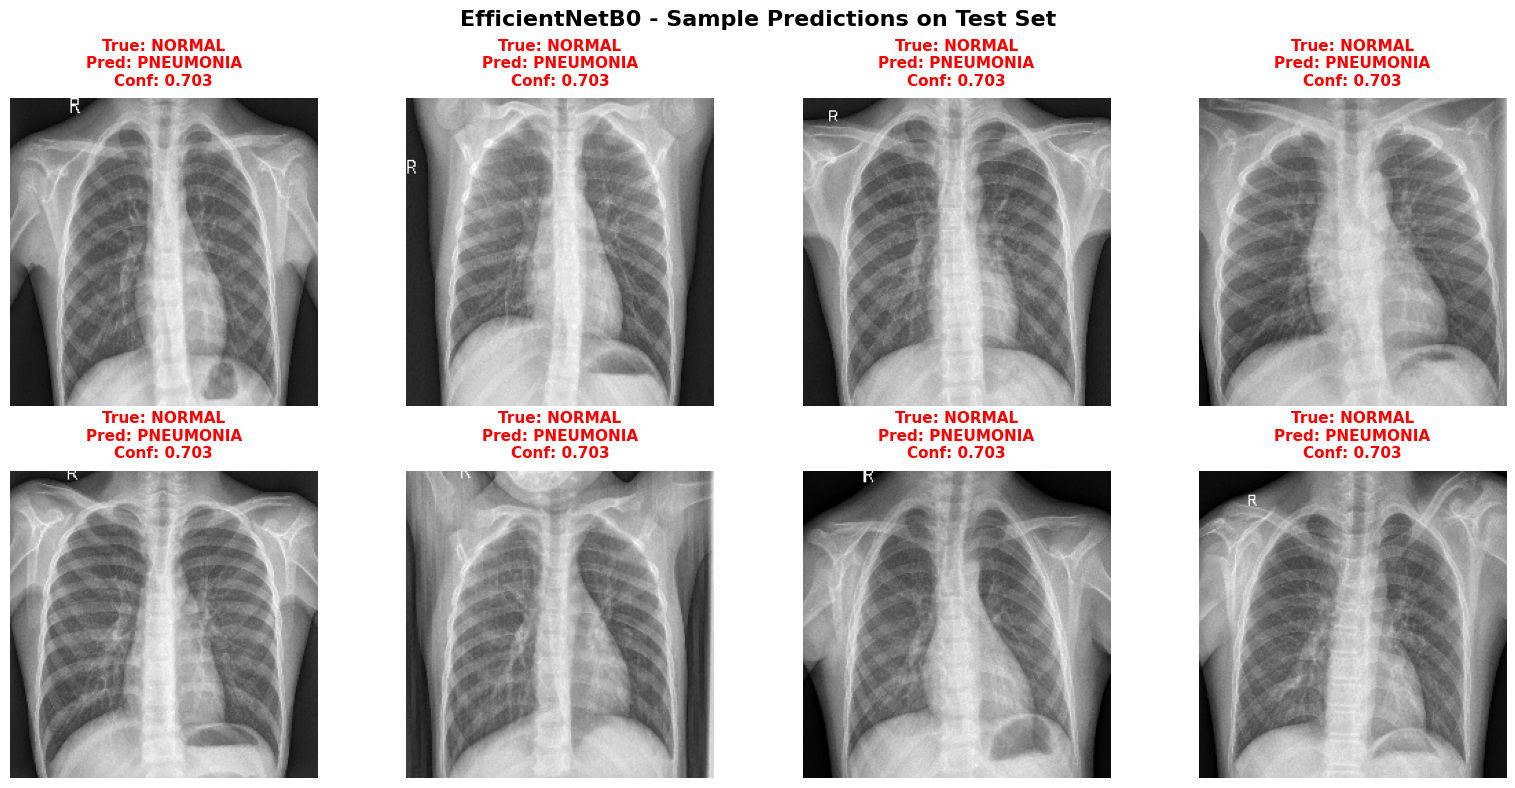

In [27]:
def display_sample_predictions(model, test_generator, num_samples=8):
    """
    Display sample predictions with true and predicted labels
    """
    # Get a batch of test data
    test_generator.reset()
    x_batch, y_batch = next(test_generator)

    # Make predictions for this batch
    predictions = model.predict(x_batch[:num_samples], verbose=0)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    true_labels = y_batch[:num_samples].astype(int)

    # Class names
    class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}

    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(x_batch[i])
        axes[i].axis('off')

        true_class = class_names[true_labels[i]]
        pred_class = class_names[predicted_labels[i]]
        confidence = predictions[i][0]

        # Color code: green for correct, red for incorrect
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'

        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
        axes[i].set_title(title, color=color, fontsize=11, fontweight='bold', pad=10)

    plt.suptitle('EfficientNetB0 - Sample Predictions on Test Set',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

display_sample_predictions(effnet_model, test_generator)

## Save the Model and Results

In [28]:
def save_results(model, history, test_metrics):
    """
    Save model, training history, and metrics
    """
    print("Saving results...")

    # Save the model
    model.save('efficientnetb0_pneumonia_detection.h5')
    print("Model saved as 'efficientnetb0_pneumonia_detection.h5'")

    # Save training history to CSV
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = range(1, len(history_df) + 1)
    history_df.to_csv('efficientnet_training_history.csv', index=False)
    print("Training history saved as 'efficientnet_training_history.csv'")

    # Save test metrics
    metrics_df = pd.DataFrame([test_metrics])
    metrics_df.to_csv('efficientnet_test_metrics.csv', index=False)
    print("Test metrics saved as 'efficientnet_test_metrics.csv'")

    # Create performance summary
    summary = {
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_auc': test_metrics['auc'],
        'training_time_minutes': training_time / 60
    }

    summary_df = pd.DataFrame([summary])
    summary_df.to_csv('model_performance_summary.csv', index=False)
    print("Performance summary saved as 'model_performance_summary.csv'")

save_results(effnet_model, history, test_metrics)

Saving results...
Model saved as 'efficientnetb0_pneumonia_detection.h5'
Training history saved as 'efficientnet_training_history.csv'
Test metrics saved as 'efficientnet_test_metrics.csv'
Performance summary saved as 'model_performance_summary.csv'
